In [ ]:
import pandas as pd
import requests
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import json
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# api key untuk ekstrak data dari web alpha vantage
api_key = "2A3KMY0GNM9JUBKA"

In [ ]:
# HISTORICAL DATA ~ TIME_SERIES_DAILY
def get_historical_data(symbol, start_date = None):
    api_url = f'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol={symbol}&apikey={api_key}&outputsize=full'
    raw_df = requests.get(api_url).json()
    df = pd.DataFrame(raw_df[f'Time Series (Daily)']).T
    df = df.rename(columns = {'1. open': 'open', '2. high': 'high', '3. low': 'low', '4. close': 'close', 
                              '5. adjusted close': 'adj close', '6. volume': 'volume'})
    for i in df.columns:
        df[i] = df[i].astype(float)
    df.index = pd.to_datetime(df.index)
#     delete kolom 'dividen amount' dan kolom 'split coefficient'
    df = df.iloc[::-1].drop(['7. dividend amount', '8. split coefficient'], axis = 1) 
    if start_date:
        df = df[df.index >= start_date]
    return df

Untuk contoh percobaan kami mencoba mengambil data historis dari saham microsoft, dengan tanggal 2010-01-01 sebagai tanggal mulainya data historis diambil. 

In [ ]:
msft_hist = get_historical_data('MSFT', '2010-01-01')
msft_hist

,open,high,low,close,adj close,volume
2010-01-04,30.62,31.100,30.59,30.950,23.906734,38409100.0
2010-01-05,30.85,31.100,30.64,30.960,23.914459,49749600.0
2010-01-06,30.88,31.080,30.52,30.770,23.767697,58182400.0
2010-01-07,30.63,30.700,30.19,30.452,23.522064,50559700.0
2010-01-08,30.28,30.880,30.24,30.660,23.682729,51197400.0
...,...,...,...,...,...,...
2021-12-06,323.95,327.450,319.23,326.190,326.190000,30032556.0
2021-12-07,331.64,335.800,330.10,334.920,334.920000,31021936.0
2021-12-08,335.31,335.500,330.80,334.970,334.970000,24760988.0
2021-12-09,334.41,336.489,332.12,333.100,333.100000,22214158.0


Note the dataframe has:
   - Date (YYY-MM-DD) as an index
   - Open (price the stock started as)
   - High (highest price stock reached that day)
   - Low (lowest price stock reached that day)
   - Close (price the stock ended the day as)
   - adj close (The adjusted closing price factors in anything that might affect the stock price after the market closes.)
   - Volume (how many shares were traded that day)
   - dividend amount (the amount of dividend to give into the shareholder)
   - split coefficient (stock split)

### mengelola missing value

In [ ]:
msft_hist.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3007 entries, 2010-01-04 to 2021-12-10
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   open       3007 non-null   float64
 1   high       3007 non-null   float64
 2   low        3007 non-null   float64
 3   close      3007 non-null   float64
 4   adj close  3007 non-null   float64
 5   volume     3007 non-null   float64
dtypes: float64(6)
memory usage: 164.4 KB


Dari hasil diatas, dapat dikatakan dataset yang diperoleh tidak ada nilai yang kosong. 

### pemilihan fitur

Setelah analisis masing-masing pengertian dari setiap fitur, fitur 'adj close' di buang karena data tersebut dikatakan cukup sama dengan kolom 'close'. keduanya merepresentasikan harga penutupan pada suatu saham.

In [ ]:
def drop_feature(df):
    return df.drop(['adj close'], axis = 1)

In [ ]:
msft_hist = drop_feature(msft_hist)

In [ ]:
msft_hist

,open,high,low,close,volume
2010-01-04,30.62,31.100,30.59,30.950,38409100.0
2010-01-05,30.85,31.100,30.64,30.960,49749600.0
2010-01-06,30.88,31.080,30.52,30.770,58182400.0
2010-01-07,30.63,30.700,30.19,30.452,50559700.0
2010-01-08,30.28,30.880,30.24,30.660,51197400.0
...,...,...,...,...,...
2021-12-06,323.95,327.450,319.23,326.190,30032556.0
2021-12-07,331.64,335.800,330.10,334.920,31021936.0
2021-12-08,335.31,335.500,330.80,334.970,24760988.0
2021-12-09,334.41,336.489,332.12,333.100,22214158.0


Untuk fitur yang akan dipakai dalam pembuatan model pada tahap 4, kami memutuskan untuk menggunakan kolom 'open', 'high', 'low', 'close', dan 'volume'. karena ke empat fitur tersebut cukup merepresentasikan harga dari suatu saham.

### normalisasi

In [ ]:
# normalisasi menggunakan formula normalisasi min - max
def normalise_min_max(df):
    return (df - df.min()) / (df.max() - df.min())

In [ ]:
msft_hist = normalise_min_max(msft_hist)

In [ ]:
msft_hist.head()

,open,high,low,close,volume
2010-01-04,0.023419,0.023839,0.024603,0.024805,0.099341
2010-01-05,0.024135,0.023839,0.024760,0.024836,0.135701
2010-01-06,0.024228,0.023778,0.024384,0.024242,0.162738
2010-01-07,0.023450,0.022614,0.023351,0.023249,0.138298
2010-01-08,0.022362,0.023165,0.023508,0.023899,0.140343


### pengelompokkan data training dan data testing 

berikut adalah fungsi (manual / tanpa bantuan library) untuk memisahkan dataset menjadi data training dan data testing.

In [ ]:
# contoh data testingnya, 20% dari dataset
def train_test_split(df, test_size=0.2):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data

In [ ]:
train, test = train_test_split(msft_hist, test_size=0.2)

In [ ]:
# train.tail()
test.head()

,open,high,low,close,volume
2019-07-26,0.364756,0.362678,0.368016,0.369666,0.037231
2019-07-29,0.368270,0.362157,0.365105,0.368697,0.029434
2019-07-30,0.364041,0.361269,0.366451,0.366573,0.030206
2019-07-31,0.364632,0.359032,0.351676,0.353827,0.099949
2019-08-01,0.354275,0.360411,0.357467,0.359419,0.106229


berikut adalah fungsi untuk memisahkan dataset menjadi data training dan data testing denga bantuan library sklearn.

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
y1 = pd.DataFrame(msft_hist['close'])
y1

,close
2010-01-04,0.024805
2010-01-05,0.024836
2010-01-06,0.024242
2010-01-07,0.023249
2010-01-08,0.023899
...,...
2021-12-06,0.947142
2021-12-07,0.974414
2021-12-08,0.974570
2021-12-09,0.968729


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(msft_hist, y1, train_size = 0.8, shuffle=False)

In [ ]:
# X_train.tail()
# X_test.head()
# y_train.tail()
# y_test.head()

fungsi untuk membuat visualisasi dataset berdasarkan data testing dan data training

In [ ]:
def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('price [CAD]', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16)

visualisasi data testing dengan data training

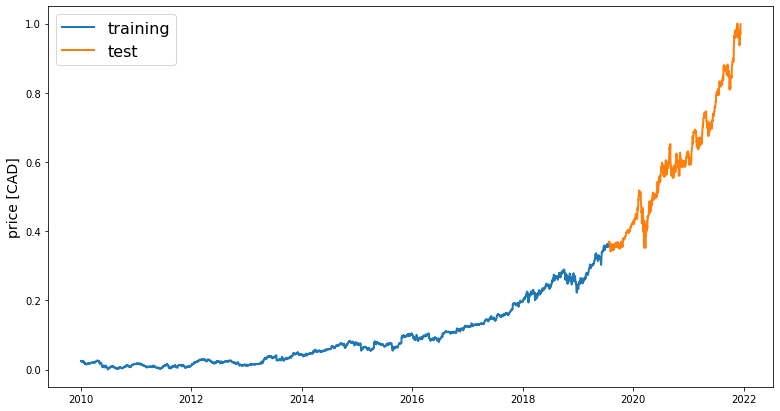

In [ ]:
target_col = 'close'
line_plot(X_train[target_col], X_test[target_col], 'training', 'test', title='')

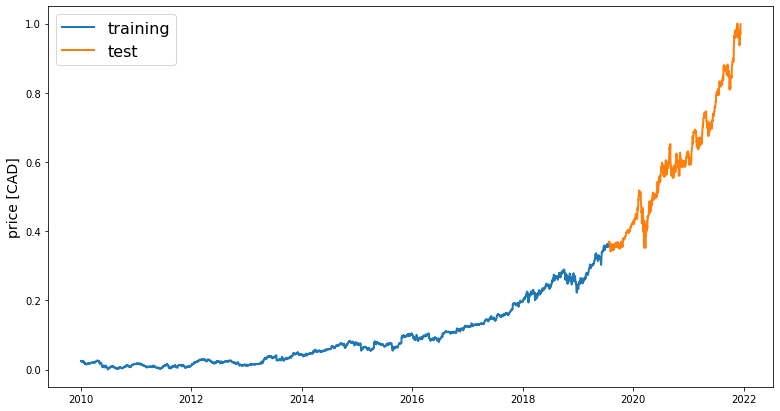

In [ ]:
line_plot(y_train, y_test, 'training', 'test', title='')

#### hasil eksplorasi dan persiapan data dari tahap 3 :
data training dan data testing dengan ukuran perbandingan 80% dan 20% dari dataset. untuk masing-masing data, terdapat fitur 'open', 'high', 'low', 'close', dan 'volume'. Dari ke empat fitur tersebut cukup merepresentasikan harga dari suatu saham. 

#Modeling

projek kami, sistem prediksi tren harga saham merupakan salah satu projek yang termasuk dalam percobaan prediksi/forecast *time series* data. *time series data* merupakan jenis data yang memiliki titik data yang diindeks atau diurutkan dalam urutan berbasis waktu. *time series forecast* adalah salah satu metode untuk membuat model untuk memprediksi nilai masa depan berdasarkan data deret waktu saat ini dan historis.

dalam tahap modeling di pembuatan projek, kami melakukan beberapa eksperimen kepada beberapa algoritma machine learning. salah satu algoritma yang akan digunakan dalam eksperimen antara lain:


*   linear regression model
*   support vector regression
*   LSTM (long short term memory) model
*   Facebook’s open-source Prophet model, prophet
*   ..

algoritma diatas merupakan algoritma yang sering digunakan untuk membuat prediksi data *time-series*. 

setelah melakukan beberapa eksperimen diatas, dari hasil data prediksi akan kami lakukan evaluasi menggunakan Mean Squared Error (MAE) untuk memilih model mana yang paling optimal untuk digunakan dalam projek kami.

### eksperimen menggunkan simple linear regression

In [ ]:
from sklearn.linear_model import LinearRegression
import seaborn as sns
import math

In [ ]:
x = msft_hist["open"].values.reshape(-1,1)
y = msft_hist["close"].values.reshape(-1,1)

In [ ]:
# X_train_lr ,X_test_lr ,y_train_lr, y_test_lr = train_test_split(x, y, train_size = 0.8, shuffle=False)

In [ ]:
msft_hist.head()

,open,high,low,close,volume
2010-01-04,0.023419,0.023839,0.024603,0.024805,0.099341
2010-01-05,0.024135,0.023839,0.024760,0.024836,0.135701
2010-01-06,0.024228,0.023778,0.024384,0.024242,0.162738
2010-01-07,0.023450,0.022614,0.023351,0.023249,0.138298
2010-01-08,0.022362,0.023165,0.023508,0.023899,0.140343


In [ ]:
msft_hist.corr()

,open,high,low,close,volume
open,1.000000,0.999912,0.999905,0.999821,-0.328207
high,0.999912,1.000000,0.999857,0.999899,-0.325544
low,0.999905,0.999857,1.000000,0.999911,-0.331467
close,0.999821,0.999899,0.999911,1.000000,-0.328926
volume,-0.328207,-0.325544,-0.331467,-0.328926,1.000000


In [ ]:
x_temp = msft_hist.open.to_numpy();
y_temp = msft_hist.close.to_numpy();
x_temp = x_temp.reshape(-1,1)
y_temp = y_temp.reshape(-1,1)
np.size(x_temp)

3007

In [ ]:
msft_hist.head(5)

,open,high,low,close,volume
2010-01-04,0.023419,0.023839,0.024603,0.024805,0.099341
2010-01-05,0.024135,0.023839,0.024760,0.024836,0.135701
2010-01-06,0.024228,0.023778,0.024384,0.024242,0.162738
2010-01-07,0.023450,0.022614,0.023351,0.023249,0.138298
2010-01-08,0.022362,0.023165,0.023508,0.023899,0.140343


In [ ]:
model_temp = LinearRegression()
model_temp.fit(x_temp,y_temp)
result = []
i = 0
while i < 3007:
  temp_result = model_temp.predict(x_temp[i].reshape(-1, 1))
  result.append(temp_result[0].tolist())
  i += 1

In [ ]:
close_arr = y_temp.tolist()
open_arr = x_temp.tolist()

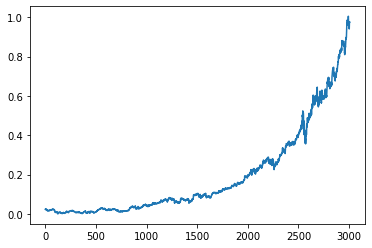

In [ ]:
plt.plot(result)

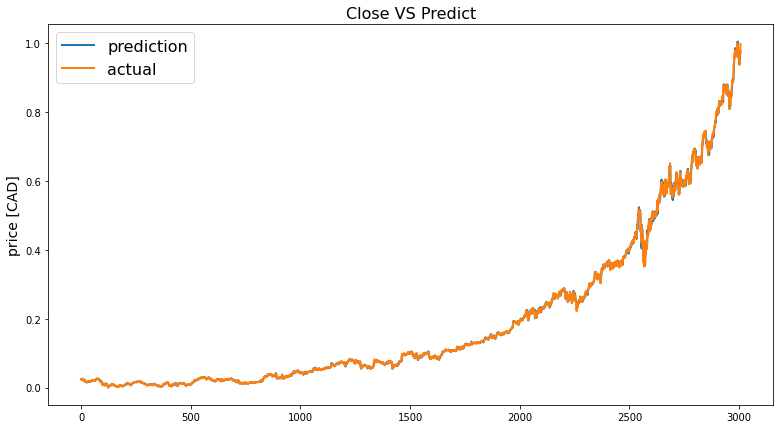

In [ ]:
line_plot(result, close_arr, 'prediction', 'actual', title='Close VS Predict')

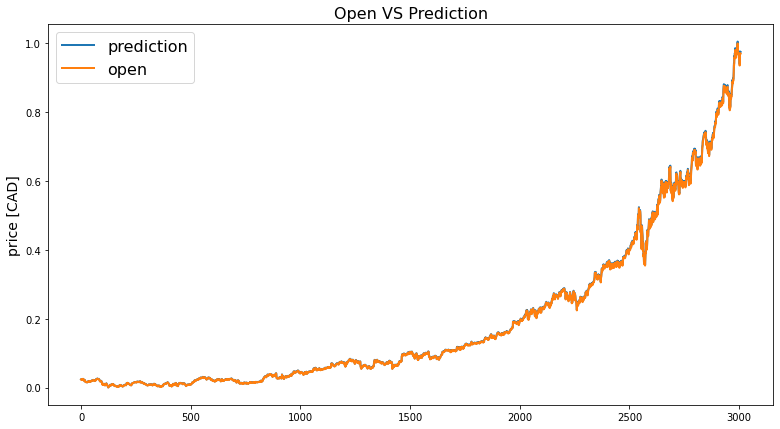

In [ ]:
line_plot(result, open_arr, 'prediction', 'open', title='Open VS Prediction')

50 Data

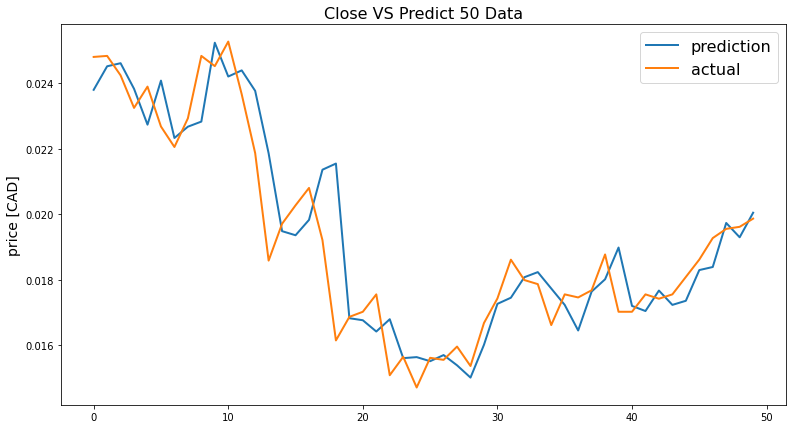

In [ ]:
line_plot(result[:50], close_arr[:50], 'prediction', 'actual', title='Close VS Predict 50 Data')

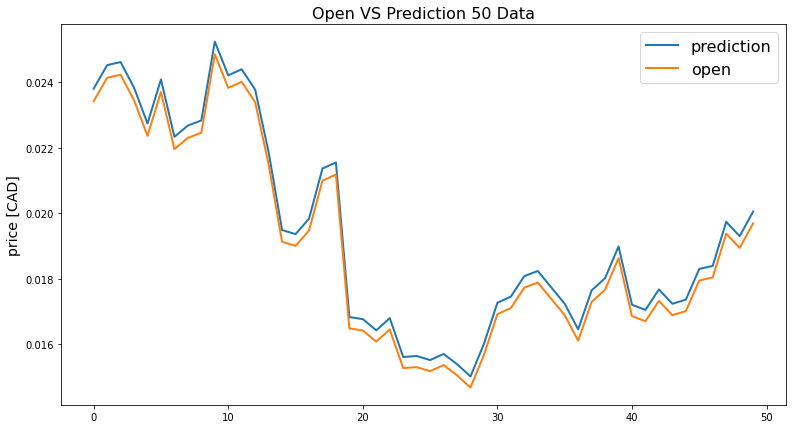

In [ ]:
line_plot(result[:50], open_arr[:50], 'prediction', 'open', title='Open VS Prediction 50 Data')

In [ ]:
print('Mean Absolute Error:', metrics.mean_absolute_error(close_arr, result))  
print('Mean Squared Error:', metrics.mean_squared_error(close_arr, result))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(close_arr, result)))  

Mean Absolute Error: 0.0024125192246256828
Mean Squared Error: 1.944219065587727e-05
Root Mean Squared Error: 0.004409329955432828


### eksperimen menggunakan support vector regression

referensi :
*   https://medium.com/it-paragon/how-we-transform-to-machine-learning-bc397dce1692
*   https://medium.com/it-paragon/support-vector-machine-regression-cf65348b6345
*   https://towardsdatascience.com/walking-through-support-vector-regression-and-lstms-with-stock-price-prediction-45e11b620650
*   https://itnext.io/learning-data-science-predict-stock-price-with-support-vector-regression-svr-2c4fdc36662

In [ ]:
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error

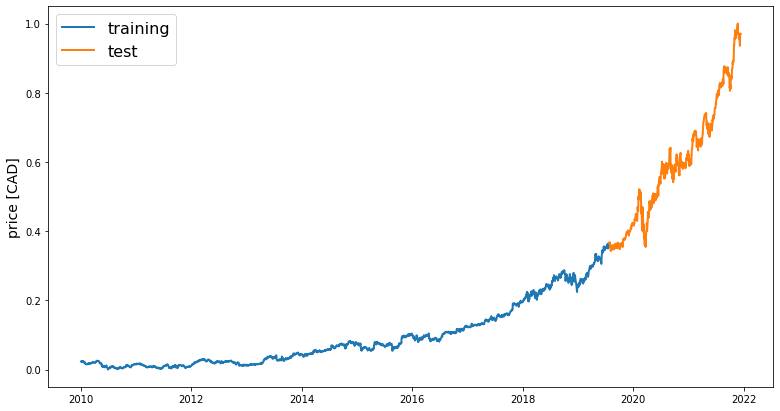

In [ ]:
# Data Preparation 
X_train_svr, X_test_svr, y_train_svr, y_test_svr = train_test_split(msft_hist, y, train_size = 0.8, shuffle=False)

# Visualisasi Data
target_col = 'open'
line_plot(X_train[target_col], X_test[target_col], 'training', 'test', title='')

In [ ]:
X_train_svr.head()

,open,high,low,close,volume
2010-01-04,0.023419,0.023839,0.024603,0.024805,0.099341
2010-01-05,0.024135,0.023839,0.024760,0.024836,0.135701
2010-01-06,0.024228,0.023778,0.024384,0.024242,0.162738
2010-01-07,0.023450,0.022614,0.023351,0.023249,0.138298
2010-01-08,0.022362,0.023165,0.023508,0.023899,0.140343


In [ ]:
drop_cols = ['high','low','close','volume']
X_train_svr = X_train_svr.drop(drop_cols, axis = 1)
X_test_svr = X_test_svr.drop(drop_cols, axis = 1)

In [ ]:
# X_train_svr
# y_train_svr

In [ ]:
# Model & Train; Model SVR menggunakan nilai Epsilon 0.01 dan Gamma 0.01, dan kernel -> rbf
svr_rbf = SVR(kernel= 'rbf', epsilon=1e-2, gamma=1e-2)
svr_rbf.fit(X_train_svr, y_train_svr.ravel())

SVR(epsilon=0.01, gamma=0.01)

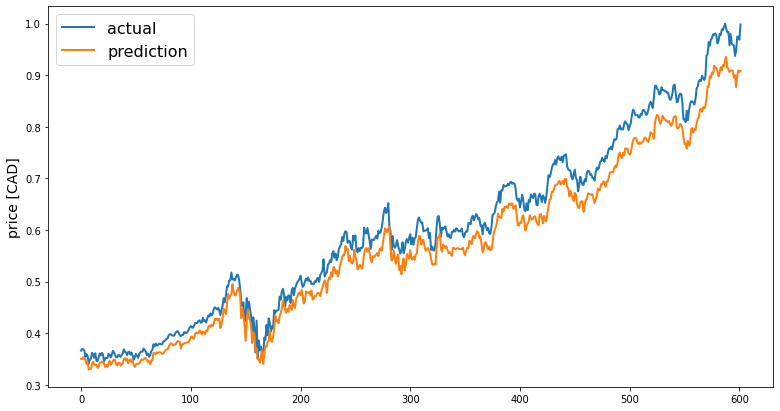

In [ ]:
# Prediction
preds_svr = svr_rbf.predict(X_test_svr)

#visualisasi
line_plot(y_test_svr, preds_svr, 'actual', 'prediction', title='')

In [ ]:
from sklearn import metrics  
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test_svr, preds_svr))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test_svr, preds_svr))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test_svr, preds_svr)))  

Mean Absolute Error: 0.035422100148647516
Mean Squared Error: 0.0015325113985150288
Root Mean Squared Error: 0.03914730384732809


### eksperiemen menggunakan LSTM (long short term memory)

referensi :

*   https://medium.com/swlh/stock-price-prediction-with-pytorch-37f52ae84632
*   https://towardsdatascience.com/cryptocurrency-price-prediction-using-deep-learning-70cfca50dd3a



In [ ]:
#import library
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

In [ ]:
#menyiapkan dataset, lalu membentuk lagi dataset menjadi data testing dan training
ds_msft = get_historical_data('MSFT', '2010-01-01')
ds_close = ds_msft.iloc[:,4:5].values

scaler = MinMaxScaler(feature_range = (0, 1))
scaled_ds_close = scaler.fit_transform(ds_close)

step = 21

X_train = []
y_train = []

for i in range(step, scaled_ds_close.shape[0]):              
    X_train.append(scaled_ds_close[i-step:i, 0])
    y_train.append(scaled_ds_close[i, 0])

stockFeature = np.array(X_train[:-1])                   
stockLabel = np.array(y_train[:-1])

n = len(ds_close)
split = int(n*0.8)

X_train_lstm = stockFeature[:split]
X_test_lstm = stockFeature[split:]
y_train_lstm = stockLabel[:split]
y_test_lstm = stockLabel[split:]

X_train_lstm = np.reshape(X_train_lstm, (X_train_lstm.shape[0], X_train_lstm.shape[1], 1))
X_test_lstm = np.reshape(X_test_lstm, (X_test_lstm.shape[0], X_test_lstm.shape[1], 1))

In [ ]:
#membangun model lstm
model = Sequential()

model.add(LSTM(units=40, return_sequences=True))
model.add(Dropout(0.15))

model.add(LSTM(units=40, return_sequences=True))
model.add(Dropout(0.15))

model.add(LSTM(units=40))
model.add(Dropout(0.15))

model.add(Dense(1))
#prediksi dengan model lstm

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train_lstm, y_train_lstm, epochs=20, batch_size=100)

Epoch 1/20
25/25 [==============================] - 7s 44ms/step - loss: 0.0042
Epoch 2/20
25/25 [==============================] - 1s 41ms/step - loss: 3.6676e-04
Epoch 3/20
25/25 [==============================] - 1s 41ms/step - loss: 2.6354e-04
Epoch 4/20
25/25 [==============================] - 1s 40ms/step - loss: 2.0090e-04
Epoch 5/20
25/25 [==============================] - 1s 41ms/step - loss: 2.0090e-04
Epoch 6/20
25/25 [==============================] - 1s 40ms/step - loss: 1.8101e-04
Epoch 7/20
25/25 [==============================] - 1s 41ms/step - loss: 1.6236e-04
Epoch 8/20
25/25 [==============================] - 1s 41ms/step - loss: 1.6428e-04
Epoch 9/20
25/25 [==============================] - 1s 42ms/step - loss: 1.7893e-04
Epoch 10/20
25/25 [==============================] - 1s 40ms/step - loss: 1.5204e-04
Epoch 11/20
25/25 [==============================] - 1s 41ms/step - loss: 1.5203e-04
Epoch 12/20
25/25 [==============================] - 1s 40ms/step - loss: 1.44

In [ ]:
#hitung nilai MAE
preds = model.predict(X_test_lstm)
mean_absolute_error(preds, y_test_lstm)

0.02807699781657717

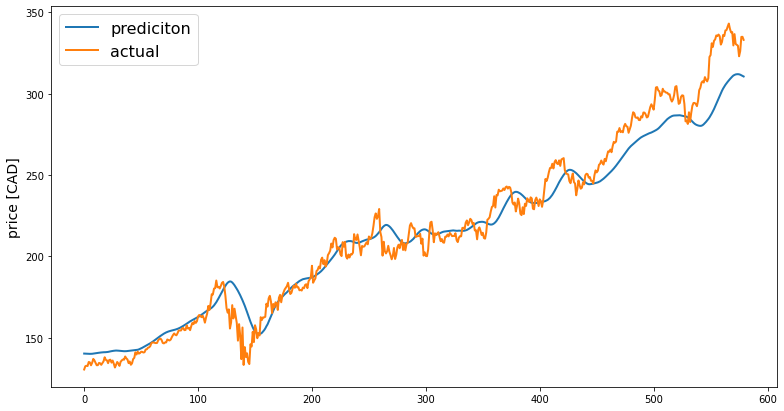

In [ ]:
# menggabungkan hasil prediction ke dataframe
lstm_predictions = model.predict(X_test_lstm)

lstm_predictions = scaler.inverse_transform(lstm_predictions)
y_test_lstm = scaler.inverse_transform(y_test_lstm.reshape(-1,1))
# visualisasi prediksi dan actual values
line_plot(lstm_predictions, y_test_lstm, 'prediciton', 'actual', title='')